<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario de Ciencia de Datos (<i>Data Science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Módulo 9: Ejemplo de DQN


En este _notebook_ vamos a ver un ejemplo de implementación de una Deep Q-Network (DQN) utilizando un entorno ya predefinido en OpenAI.

Tanto para este ejemplo como para las posteriores prácticas se utilizará el <i>framework</i> de __Pytorch__. 


## 1. Entorno CartPole

En este ejemplo usaremos un entorno ya definido en la librería de OpenAI, pero hay que tener presente que en otros problemas más concretos el entorno necesitará ser definido.

CartPole consiste en aprender a controlar un objeto. El juego consta de una carretilla y de un palo colocado verticalmente encima de la carretilla. El palo se aguanta únicamente por la gravedad, mientras que la carretilla se mueve a derecha e izquierda sin parar. El objetivo del agente es controlar la velocidad de la carretilla, aumentándola o disminuyéndola con tal de evitar que el palo se caiga.

### 1.1. Establecer el entorno

En primer lugar cargaremos la librería __gym__ e inicializaremos el entorno.

In [12]:
import gym

env = gym.envs.make("CartPole-v0")

Cada entorno tiene definido todo lo necesario para que un agente pueda aprender: tenemos un juego que funciona de una manera determinada y nosotros podemos entrenar a un agente para que aprenda a jugar a ese juego sin ninguna ayuda más que la de experimentar con él observando, actuando y recibiendo recompensas. Así, el entorno del juego ya define qué acciones se pueden tomar, qué situaciones pueden presentarse, en qué consistirá la recompensa, etc. 

A continuación, podemos visualizar el entorno de __CartPole__ generando un bucle sobre unos pocos episodios y, al terminar, lo cerramos. 

In [13]:
#Visualizamos el entorno
for i_episode in range(15):
    observation = env.reset()
    for t in range(100):
        env.render() #EL RENDER SÓLO FUNCIONA EN LOCAL: comentar línea si no se está en local.
        print(observation)
        action = env.action_space.sample() #acción aleatoria
        observation, reward, done, info = env.step(action) #ejecución de la acción elegida
        if done:
            print("Episode finished after {} timesteps".format(t+1)) 
            break
env.close() #cerramos la visualización del entorno

[ 0.03635958 -0.00120473 -0.03870554 -0.04141664]
[ 0.03633549 -0.19575089 -0.03953387  0.23880745]
[ 3.24204678e-02 -8.71238610e-05 -3.47577201e-02 -6.60788119e-02]
[ 0.03241873  0.19551547 -0.0360793  -0.3695222 ]
[ 0.03632903  0.00092422 -0.04346974 -0.0884303 ]
[ 0.03634752  0.19664143 -0.04523835 -0.39450486]
[ 0.04028035  0.00218961 -0.05312844 -0.11642108]
[ 0.04032414 -0.19213244 -0.05545687  0.1590383 ]
[ 0.03648149  0.00373782 -0.0522761  -0.15061136]
[ 0.03655625 -0.19059812 -0.05528833  0.12513214]
[ 0.03274429 -0.3848862  -0.05278568  0.39987247]
[ 0.02504656 -0.57922118 -0.04478823  0.67545714]
[ 0.01346214 -0.77369306 -0.03127909  0.95370909]
[-0.00201172 -0.57816456 -0.01220491  0.65136525]
[-1.35750150e-02 -7.73114422e-01  8.22395378e-04  9.40180106e-01]
[-0.0290373  -0.96824745  0.019626    1.23312133]
[-0.04840225 -1.16361617  0.04428842  1.53188766]
[-0.07167458 -0.9690551   0.07492618  1.25334875]
[-0.09105568 -0.77496853  0.09999315  0.98504341]
[-0.10655505 -0.58

La recompensa es 1 por cada paso dado, incluyendo el estado terminal. Se considera el entorno resuelto cuando la media de las recompensas es mayor o igual a 195.0 tras 100 intentos consecutivos.

## 2. Construcción de una DQN: enseñar a un agente a jugar

La construcción de una DQN para enseñar a un agente a jugar a **CartPole** pasa, como hemos visto en el módulo didáctico, por los siguientes pasos:

<ol>
    <li> Definir el modelo de red neuronal. </li>
    <li> Definir el agente: cómo se debe comportar, cuándo debe seleccionar una acción y cómo. </li>
    <li> Fijar hiperparámetros. </li>
    <li> Entrenar al agente.  </li>
    
</ol>


Empezaremos importando la librería para trabajar en **Pytorch** y otras librerías necesarias:

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### 2.1. Definición del modelo

El primer paso es definir nuestra red neuronal, la DQN. Para este ejemplo, usaremos una red neuronal muy sencilla con tres capas lineales y dos capas ReLU, además del optimizador Adam.

También indicaremos la posibilidad de trabajar con **CPU** o **CUDA** por si se tiene la opción, puesto que en aprendizaje por refuerzo la mayoría de los procesos suelen requerir mucha máquina y la aceleración por hardware es normalmente necesaria. **Este ejemplo se puede ejecutar con CPU**.


Como se explicaba en el módulo teórico, para que el aprendizaje prospere es importante que las aproximaciones de _Q_ sean lo suficientemente buenas para que las experiencias aporten información relevante al agente. Si no se consiguen buenos valores, el agente corre el riesgo de estancarse entre decisiones malas sin mostrar ninguna mejora. Para ello se introduce el **método <i>e-greedy</i>**, que permite al agente explorar acciones aleatorias durante un tiempo al inicio del entrenamiento y facilita que vaya pasando a utilizar la aproximación de _Q_ poco a poco (explotación). Recordemos que este comportamiento viene definido por el hiperparámetro de probabilidad <i>epsilon</i>.

In [15]:
class DQN(torch.nn.Module):
    
    def __init__(self, env, learning_rate=1e-3, device='cpu'):
        super(DQN, self).__init__()
        self.device = device
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        ### Construcción de la red neuronal
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(16, self.n_outputs, bias=True))
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        
        ### Se ofrece la opción de trabajar con CUDA
        if self.device == 'cuda':
            self.model.cuda()
            
    
    ### Método e-greedy
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción aleatoria
        else:
            qvals = self.get_qvals(state)  # acción a partir del cálculo del valor de Q para esa acción
            action= torch.max(qvals, dim=-1)[1].item()
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.model(state_t)

#### 2.1.1. _Buffer_ de repetición de experiencias

Otro problema del algoritmo básico de la DQN era la secuencialidad de los datos: los estados están muy correlacionados y la red neuronal no puede funcionar bien con tanta correlación. Introduciendo un **<i>buffer</i> de repetición de experiencias** permitimos que se almacenen unas cuantas experiencias pasadas y que se pase un subconjunto aleatorio de estas a la red neuronal. A su vez, el *buffer* se tiene que ir alimentando de experiencias nuevas conforme el agente va aprendiendo.

Importamos primero las funciones `deque` y `namedtuple` de la librería `collections`. El *deque* es un objeto que almacena valores hasta un límite fijado. Cuando se llega al límite, el *deque* elimina el primer valor para que pueda entrar uno nuevo, y así sucesívamente, facilitando, en nuestro caso, la retroalimentación del *buffer* con experiencias más nuevas y cada vez más relevantes.

In [16]:
from collections import namedtuple, deque

Definimos el __<i>buffer</i> de repetición de experiencias__:

In [17]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    ##Creamos una lista de índices aleatorios y empaquetamos las experiencias en arrays de Numpy (facilita el cálculo posterior de la pérdida)
    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    ## Se añaden las nuevas experiencias 
    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    ## Rellenamos el buffer con experiencias aleatorias al inicio del entrenamiento
    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

El *burn-in* nos permite rellenar el *buffer* al inicio del entrenamiento (cuando el agente aún no ha empezado a explorar) con experiencias aleatorias para que esté suficientemente lleno como para empezar a entrenar con una variedad de información bastante amplia. 

### 2.2. Definición del agente

Una vez tenemos el modelo definido, solo nos queda definir el comportamiento del agente, el cómo aprende.

Recordemos que la última mejora que hacíamos a la DQN básica y que nos permitía establecer el algoritmo DQN final era la introducción de una **red objetivo**. Con esta segunda red (copia exacta de la principal), calculamos el valor objetivo _Q'_ mientras que con la red principal calculamos el valor de _Q_ actual. Y cada cierto tiempo se sincronizan las dos redes. Así, conseguimos evitar que el agente se estanque en una región debido a que la diferencia entre estados sea tan pequeña (correlación), que siempre elija la misma acción y que termine por aprender erróneamente. 

Básicamente, el proceso que seguirá el agente será el siguiente:
<ol>
    <li> Rellenar el _buffer_ con unas cuantas experiencias aleatorias. </li>
    <li> Interactuar con el entorno (dar un paso): 
        <ul>
            <li> Tomar acción según la probabilidad <i>epsilon</i>. </li>
            <li> Almacenar la información en el <i>buffer</i>. </li>
            <li> Obtener la recompensa si se encuentra al final del episodio en cuestión. </li>
        </ul>
    </li>
    <li> Actualizar la red neuronal con la frecuencia que se establezca y calcular la pérdida. </li>
    <li> Sincronizar la red principal con la red objetivo con la frecuencia que se establezca. </li>
    <li> Calcular la media de las recompensas de los últimos _X_ episodios (generalmente 100). </li>
    <li> Modificar el valor de <i>epsilon</i> para favorecer la explotación frente a la exploración. </li>
</ol>

El agente repetirá este proceso hasta que consiga el objetivo a partir del cual se considera que ha aprendido a jugar (en **CartPole** es 195, como se indica en la variable `env.spec.reward_threshold`) o hasta que se agote el límite máximo de episodios establecido (hiperparámetro fijado).

In [18]:
from copy import deepcopy, copy

In [19]:
class DQNAgent:
    
    def __init__(self, env, dnnetwork, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        
        self.env = env
        self.dnnetwork = dnnetwork
        self.target_network = deepcopy(dnnetwork) # red objetivo (copia de la principal)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 # bloque de los X últimos episodios de los que se calculará la media de recompensa
        self.reward_threshold = self.env.spec.reward_threshold # recompensa media a partir de la cual se considera
                                                               # que el agente ha aprendido a jugar
        self.initialize()
    
    
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
        
    
    ## Tomamos una nueva acción
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            # acción aleatoria en el burn-in y en la fase de exploración (epsilon)
            action = self.env.action_space.sample() 
        else:
            # acción a partir del valor de Q (elección de la acción con mejor Q)
            action = self.dnnetwork.get_action(self.state0, eps)
            self.step_count += 1
            
        # Realizamos la acción y obtenemos el nuevo estado y la recompensa
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # guardamos experiencia en el buffer
        self.state0 = new_state.copy()
        
        if done:
            self.state0 = env.reset()
        return done

    
        
    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
               
                # Actualizamos la red principal según la frecuencia establecida
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                # Sincronizamos la red principal y la red objetivo según la frecuencia establecida
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.dnnetwork.state_dict())
                    self.sync_eps.append(episode)
                    
                
                if gamedone:                   
                    episode += 1
                    self.training_rewards.append(self.total_reward) # guardamos las recompensas obtenidas
                    self.update_loss = []
                    mean_rewards = np.mean(   # calculamos la media de recompensa de los últimos X episodios
                        self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)

                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    # Comprobamos que todavía quedan episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break
                    
                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego  
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break
                    
                    # Actualizamos epsilon según la velocidad de decaimiento fijada
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)
                    
                
    ## Cálculo de la pérdida                   
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards).to(device=self.dnnetwork.device) 
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1).to(
            device=self.dnnetwork.device)
        dones_t = torch.ByteTensor(dones).to(device=self.dnnetwork.device)
        
        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.dnnetwork.get_qvals(states), 1, actions_vals)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        # Calculamos la ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        # Calculamos la pérdida
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        return loss
    

    
    def update(self):
        self.dnnetwork.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.dnnetwork.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        if self.dnnetwork.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())
            


    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.axhline(self.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()


### 2.3. Hiperparámetros

Fijamos los hiperparámetros necesarios:

In [20]:
lr = 0.001            #Velocidad de aprendizaje
MEMORY_SIZE = 100000  #Máxima capacidad del buffer
MAX_EPISODES = 5000   #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)
EPSILON = 1           #Valor inicial de epsilon
EPSILON_DECAY = .99   #Decaimiento de epsilon
GAMMA = 0.99          #Valor gamma de la ecuación de Bellman
BATCH_SIZE = 32       #Conjunto a coger del buffer para la red neuronal
BURN_IN = 1000        #Número de episodios iniciales usados para rellenar el buffer antes de entrenar
DNN_UPD = 1           #Frecuencia de actualización de la red neuronal 
DNN_SYNC = 2500       #Frecuencia de sincronización de pesos entre la red neuronal y la red objetivo

### 2.4. Entrenamiento

Creamos el *buffer* de repetición de experiencias:

In [21]:
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

Cargamos el modelo de red neuronal:

In [22]:
dqn = DQN(env, learning_rate=lr)

Creamos nuestro agente:

In [23]:
agent = DQNAgent(env, dqn, buffer, EPSILON, EPSILON_DECAY, BATCH_SIZE)

Entrenamos al agente con los hiperparámetros establecidos:

In [24]:
agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES, 
              batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC)

Filling replay buffer...
Training...
Episode 6 Mean Rewards 27.67 Epsilon 0.9509900498999999		

<ipython-input-19-db5f1916c670>:117: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629434582/work/aten/src/ATen/native/IndexingUtils.h:20.)
  qvals_next[dones_t] = 0 # 0 en estados terminales


Episode 2225 Mean Rewards 195.50 Epsilon 0.01		18606165716			
Environment solved in 2225 episodes!


### 2.5. Representar el aprendizaje del agente

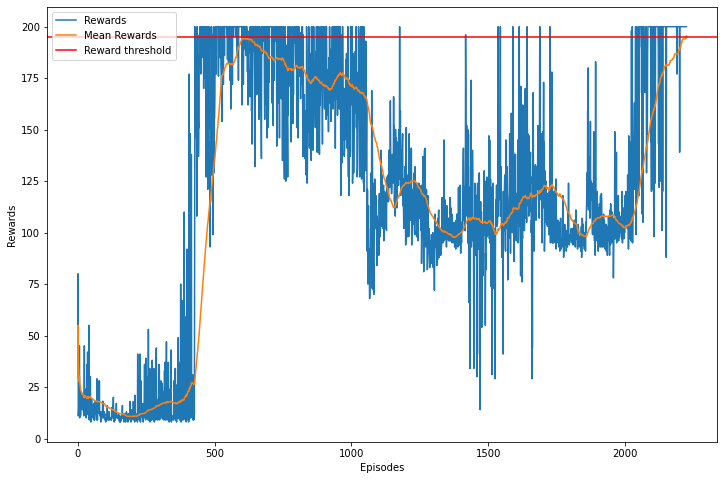

In [25]:
agent.plot_rewards()